In [2]:
import cv2
import numpy as np
from google.colab import files
from matplotlib import pyplot as plt
from scipy.ndimage import median_filter, uniform_filter

In [3]:
# Upload an image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the path of the uploaded image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Saving 11-02-2024 (23).JPG to 11-02-2024 (23).JPG


# Gaussian Noise

In [4]:
def add_gaussian_noise(image, mean=0, var=0.01):
    row, col, ch = image.shape
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy_image = image + gauss * 255
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

# Salt and pepper noise

In [10]:
def add_salt_pepper_noise(image, salt=0.005, pepper=0.005):
    noisy_image = np.copy(image)
    num_salt = np.ceil(salt * np.prod(image.shape[:2])).astype(int)
    num_pepper = np.ceil(pepper * np.prod(image.shape[:2])).astype(int)

    # Add salt noise
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], :] = 255

    # Add pepper noise
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], :] = 0

    return noisy_image


# Mean Filter

In [6]:
def apply_mean_filter(image, kernel_size=3):
    return cv2.blur(image, (kernel_size, kernel_size))

# Geometric mean Filter

In [12]:
def apply_geometric_mean_filter(image, kernel_size=3):
    # Convert image to float32 to ensure compatibility with SciPy functions
    img = image.astype(np.float32) + 1  # Prevent log(0) by adding 1
    log_img = np.log(img)  # Compute logarithm
    log_img_filtered = uniform_filter(log_img, size=kernel_size)  # Apply uniform filter in log domain
    geo_mean_img = np.exp(log_img_filtered) - 1  # Inverse log: compute geometric mean
    return np.clip(geo_mean_img, 0, 255).astype(np.uint8)  # Convert back to uint8



# Harmonic Mean Filter

In [8]:
def apply_harmonic_mean_filter(image, kernel_size=3):
    image_inverse = np.where(image > 0, 1.0 / (image.astype(np.float32)), 0)
    harmonic_mean = 1.0 / (uniform_filter(image_inverse, size=kernel_size) + 1e-9)  # Avoid divide by zero
    return np.clip(harmonic_mean, 0, 255).astype(np.uint8)

# Apply noise and filters

<ipython-input-8-4f47782f1b6e>:2: RuntimeWarning: divide by zero encountered in divide
  image_inverse = np.where(image > 0, 1.0 / (image.astype(np.float32)), 0)


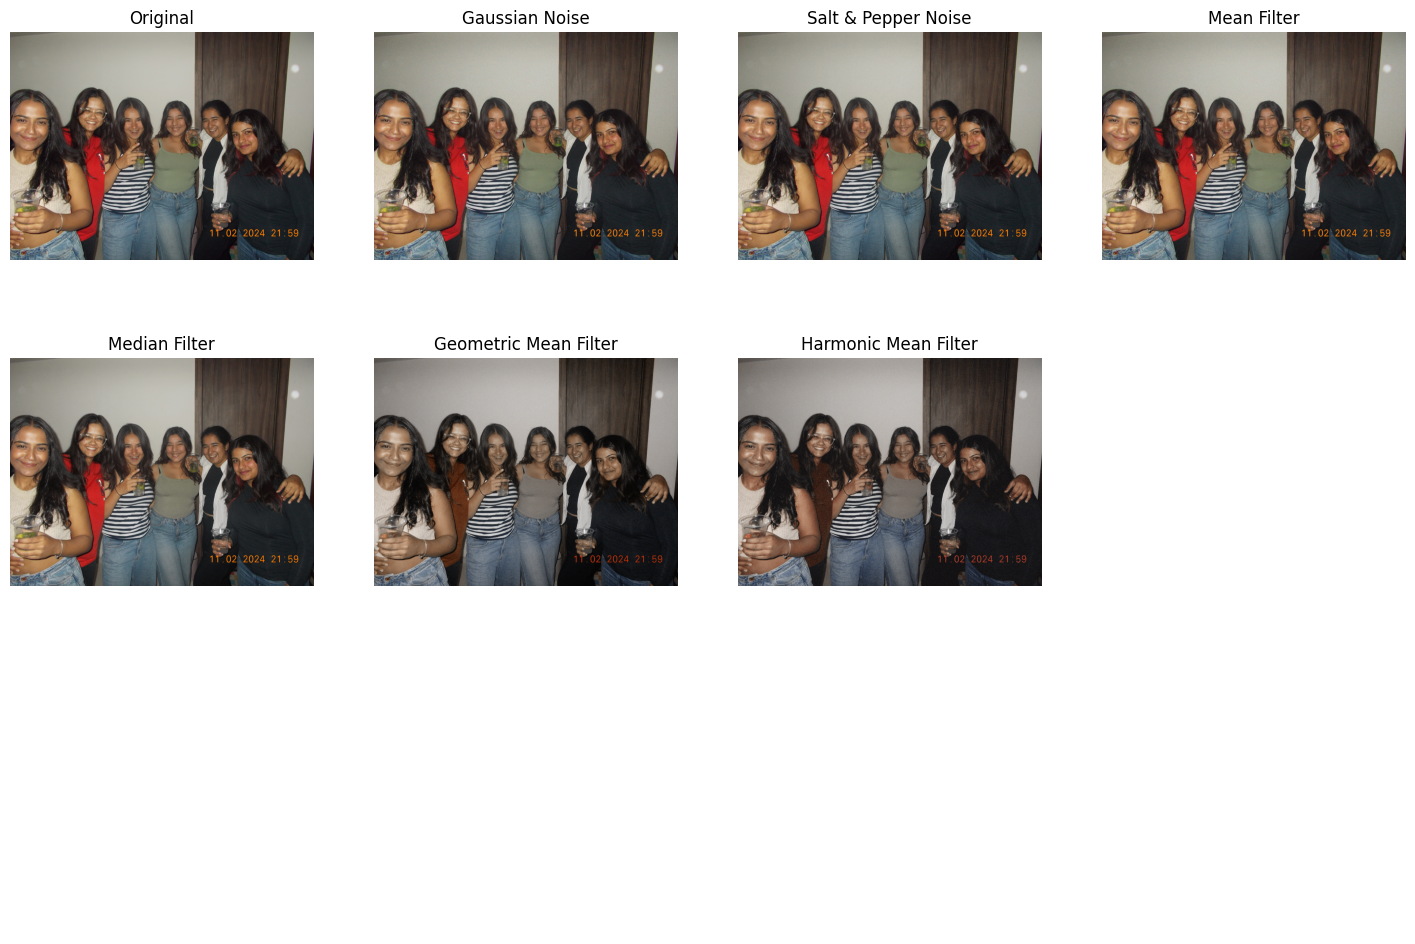

In [13]:
gaussian_noisy_image = add_gaussian_noise(image)
salt_pepper_noisy_image = add_salt_pepper_noise(image)
mean_filtered = apply_mean_filter(gaussian_noisy_image)
median_filtered = median_filter(salt_pepper_noisy_image, size=3)
geo_mean_filtered = apply_geometric_mean_filter(gaussian_noisy_image)
har_mean_filtered = apply_harmonic_mean_filter(gaussian_noisy_image)

# Displaying the results
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
titles = ['Original', 'Gaussian Noise', 'Salt & Pepper Noise', 'Mean Filter',
          'Median Filter', 'Geometric Mean Filter', 'Harmonic Mean Filter']

images = [image, gaussian_noisy_image, salt_pepper_noisy_image, mean_filtered,
          median_filtered, geo_mean_filtered, har_mean_filtered]

for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i], cmap='gray' if len(images[i].shape) == 2 else None)
        ax.set_title(titles[i])
    ax.axis('off')

plt.show()

**Gaussian Noise**: Adds pixel-wise variability following a Gaussian distribution, simulating electronic sensor noise and resulting in a 'snowy' image.

**Salt and Pepper Noise**: Randomly introduces white (salt) and black (pepper) pixels, mimicking dead pixels or bits of dust on a camera sensor.

**Median Filter**: Replaces each pixel with the median value from its neighborhood, effectively reducing salt and pepper noise while preserving edges.

**Mean Filter**: Replaces each pixel with the average of its neighbors, smoothing the image and reducing Gaussian noise but blurring edges.

**Geometric Mean Filter**: Applies the nth root of the product of n neighboring pixel values, reducing Gaussian noise while better preserving edges compared to the mean filter.

**Harmonic Mean Filter**: Utilizes the reciprocal of the average of reciprocals of pixel values, highly effective against Gaussian noise and especially useful for images with salt noise.